In [ ]:
import pandas as pd
import numpy as np
##Leser inn datasett
df4=pd.read_csv("4eren_uke5.csv", header=0)

##konverterer tider til datetime
df4["departureTime"] = pd.to_datetime(df4["departureTime"])
df4["arrivalTime"] = pd.to_datetime(df4["arrivalTime"])
df4["aimedArrivalTime"] = pd.to_datetime(df4["aimedArrivalTime"])
df4["aimedDepartureTime"] = pd.to_datetime(df4["aimedDepartureTime"])
df4["operatingDate"] = pd.to_datetime(df4["operatingDate"])


## legger til avvik
df4["delayArrival"]=df4["arrivalTime"]-df4["aimedArrivalTime"] # for første stopp i ruten vil denne være NaT
df4["delayDeparture"]=df4["departureTime"]-df4["aimedDepartureTime"] # for siste stopp i ruten vil denne være NaT

##legger til rutetidUtenDato: (altså forventet avgangsttid, hvis den er null så forventet ankomststid (siste stopp i ruten))
df4["rutetidUtenDato"] = np.where(
    pd.isnull(df4["aimedDepartureTime"]),
    df4["aimedArrivalTime"].dt.time,
    df4["aimedDepartureTime"].dt.time
)

print(df4.head(5))
print(df4.shape)
print(df4.info())


      lineRef    stopPointRef serviceJourneyId aimedDepartureTime  \
0  SKY:Line:4  NSR:Quay:53799  18186256_186816                NaT   
1  SKY:Line:4  NSR:Quay:53799  18186303_186816                NaT   
2  SKY:Line:4  NSR:Quay:53799  18186261_186816                NaT   
3  SKY:Line:4  NSR:Quay:55873  18186188_186816                NaT   
4  SKY:Line:4  NSR:Quay:53799  18186273_186816                NaT   

  departureTime          aimedArrivalTime               arrivalTime  \
0           NaT 2025-01-27 14:11:00+00:00 2025-01-27 14:08:58+00:00   
1           NaT 2025-01-27 18:54:00+00:00 2025-01-27 18:54:24+00:00   
2           NaT 2025-01-27 15:01:00+00:00 2025-01-27 15:09:25+00:00   
3           NaT 2025-01-27 17:46:00+00:00 2025-01-27 17:50:57+00:00   
4           NaT 2025-01-27 17:07:00+00:00 2025-01-27 17:04:29+00:00   

   dayOfTheWeek operatingDate  directionRef  sequenceNr      delayArrival  \
0             1    2025-01-27             2          40 -1 days +23:57:58   
1   

Her ser vi kjernestrukturen i datasettet, med et par ekstra kolonner jeg legger til for nettopp det jeg ønsker å undersøke. Må deale med tidsobjekter, har knotet litt her. 

| begrep   | forklaring |
| -------- | ---------- |
| lineRef  | referanse til linjen, syntaks "SKY:Line:{linjenummer}"|
| stopPointRef | referanse til stopp. Refererer til konkret platform (eks Fyllingsdalen terminal C). syntaks "NSR:Quay:{idnummer}". Kan søkes opp på https://stoppested.entur.org/  |
| serviceJourneyId   |  id tilknyttet bussavgang. syntaks: {langt tall1}-{langt tall2}, der tall2 er likt for hele linjen (i en retning?). id vil være lik for hver bussavgang (altså f.eks 7.30 avgangen hverdager, men ikke nødvendigvis 7.30 lørdag. Har ikke 100% oversikt her)   |
|aimedDepartureTime| rutetabellbestemt avgangstid til gitt stopp. syntaks: datetimeobj (?),2025-01-27 14:11:00+00:00. Nullobj: NaT |
|departureTime| faktisk avgangstid fra det stoppet|
|aimedArrivalTime| rutetabellbestemt ankomsttid til gitt stopp. syntaks: datetimeobj (?),2025-01-27 14:11:00+00:00. Nullobj: NaT |
|arrivalTime| faktisk ankomsttid til det stoppet, syntaks: datetimeobj (?),2025-01-27 14:11:00+00:00. Nullobj: NaT |
|dayOfTheWeek| ukedag, representert med et tall fra 1-7, der 1 er mandag og 7 er søndag|
|operatingDate| hvilken dag bussen kjører på. litt usikker på hvor grensen går for avganger som går over midnatt, omdenne endres underveis i ruten eller gjelder for hele avgangen. Definert som "date of the vehicle journey"|
|directionRef| enten 1 eller 2, (outbound eller inbound)|
|sequenceNr| nr i rekkefølge av stopp, men om de er i riktig rekkefølge er usikkert. undersøk!|
|delayArrival| utregnet avvik ved ankomst, syntaks: samme som tidligere|
|delayDeparture|utregnet avvik ved avgang, syntaks: samme som tidligere|
|ruteTidUtenDato| klokkeslett for avgang (har senere funnet ut at denne går en time for seint (dette gjelder også alle de andre tidspunktene)), uten dato. For enklere plotting. Syntaks: hh:mm:ss|
|stopName| OBS: Legges til lenger nede i notebooken. Navnet til stoppestedet, hentes fra rutetabellfil stops.txt (lastet ned fra entur en gang for lenge siden)|


In [ ]:
##Finner de 10 største forsinkelsene
toppliste = df4.sort_values(by="delayArrival", ascending=False).head(10)
print(toppliste[["serviceJourneyId", "stopPointRef", "delayArrival", "delayDeparture", "aimedDepartureTime"]])


##Finner de 10 mest forsinkede avgangene OBS DETTE FORUTSETTER AT MIN FORSÅTLESE AV SERVICEJOURNEYID ER RIKTIG
avganger = df4[["serviceJourneyId", "delayDeparture"]].groupby('serviceJourneyId').agg({'delayDeparture': ['max','mean','min']}).reset_index()
avganger.columns = ['serviceJourneyId', 'maxDelayDeparture', 'meanDelayDeparture', 'minDelayDeparture']
avganger=avganger.sort_values(by="meanDelayDeparture", ascending=False)
print(avganger.head(10))
print(avganger.shape) ##antall avganger - skal det virkelig være 492?

      serviceJourneyId    stopPointRef    delayArrival  delayDeparture  \
24099  18186291_186816  NSR:Quay:53752 0 days 00:26:52 0 days 00:26:54   
24094  18186291_186816  NSR:Quay:49579 0 days 00:26:35 0 days 00:26:47   
24081  18186291_186816  NSR:Quay:53425 0 days 00:26:33 0 days 00:26:49   
24090  18186291_186816  NSR:Quay:53438 0 days 00:26:32 0 days 00:26:51   
24083  18186291_186816  NSR:Quay:53429 0 days 00:26:30 0 days 00:26:46   
24087  18186291_186816  NSR:Quay:53434 0 days 00:26:17 0 days 00:26:23   
24127  18186291_186816  NSR:Quay:53782 0 days 00:26:13 0 days 00:26:25   
24122  18186291_186816  NSR:Quay:53779 0 days 00:26:02 0 days 00:26:18   
24115  18186291_186816  NSR:Quay:53773 0 days 00:25:57 0 days 00:25:57   
24110  18186291_186816  NSR:Quay:53756 0 days 00:25:56 0 days 00:26:11   

             aimedDepartureTime  
24099 2025-01-29 21:34:00+00:00  
24094 2025-01-29 21:33:00+00:00  
24081 2025-01-29 21:29:00+00:00  
24090 2025-01-29 21:32:00+00:00  
24083 2025-01-2

492


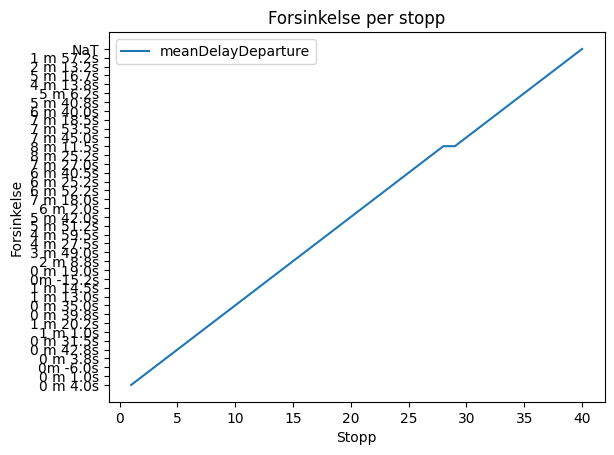

In [ ]:
import matplotlib.pyplot as plt
stoppested=pd.read_csv("stops.txt", header=0, sep=",")
def finnNavn(stop_id):
    return stoppested[stoppested["stop_id"]==stop_id]["stop_name"].values[0]

#litt finere formatering av tiden - lesbarhet for utskrivning av tabell
def stringFormatering(delayDeparture):
    try:
        if (delayDeparture.total_seconds()//60) < 0:
            return f"{int(delayDeparture.total_seconds()//60+1)}m {round(delayDeparture.total_seconds()%60-60,1)}s"
        else:
            return f"{int(delayDeparture.total_seconds()//60)} m {round(delayDeparture.total_seconds()%60,1)}s"
    except ValueError:
        return "NaT"
    
    
##undersøker videre for å sjekke om en servicejourney virkelig er en avgang
print(df4["serviceJourneyId"].nunique()) ##antall unike serviceJourneyId



avgang=df4[df4["serviceJourneyId"]=="18186256_186816"]
# print(avgang.shape)
# print(avgang["stopPointRef"].nunique())##antall unike stopPointRef
# print(avgang.groupby("stopPointRef").size()) ##antall avganger per stopPointRef - dette blir 5, som kan stemme med en avgang mandag-fredag
stoppesteder=avgang["stopPointRef"].unique()
# for stopp in stoppesteder:
#     print(finnNavn(stopp))

avgang=avgang[["stopPointRef","delayDeparture","sequenceNr"]].groupby("sequenceNr").agg({"delayDeparture":['max','mean','min'],"stopPointRef":"first"}).reset_index()
avgang.columns=["sequenceNr","maxDelayDeparture","meanDelayDeparture","minDelayDeparture","stopPointRef"]
avgang["stopName"]=avgang["stopPointRef"].apply(finnNavn)

##om du vil printe ut tabellen
'''
avgang["maxDelayDeparture"]=avgang["maxDelayDeparture"].apply(stringFormatering)
avgang["meanDelayDeparture"]=avgang["meanDelayDeparture"].apply(stringFormatering)
avgang["minDelayDeparture"]=avgang["minDelayDeparture"].apply(stringFormatering)
print(avgang)
'''

xverdier=avgang["sequenceNr"]
yverdier=avgang["meanDelayDeparture"]
plt.figure()
plt.plot(xverdier,yverdier, label="meanDelayDeparture")
plt.legend()
plt.xlabel("Stopp")
plt.ylabel("Forsinkelse")
plt.title("Forsinkelse per stopp")
plt.show()


In [ ]:
df3=df4.copy()

##fjerner rader med null
df3=df3.dropna()
##avgrenser til kun en retning
#df3=df3[df3["directionRef"]==1]

##print(df3.head(5))
##df group by stop point ref, mean delay
# mean_delay = df3[["sequenceNr", "stopPointRef", "delayDeparture"]].groupby("sequenceNr").agg({"delayDeparture":"mean", "stopPointRef":"first"}).reset_index()
# mean_delay = mean_delay.sort_values(by="delayDeparture", ascending=False)
# størsteAvvik=mean_delay.head(5)
# minsteAvvik=mean_delay.tail(5)

##henter inn navnene til stoppene
stoppested=pd.read_csv("stops.txt", header=0, sep=",")
def finnNavn(stop_id):
    return stoppested[stoppested["stop_id"]==stop_id]["stop_name"].values[0]

# print(finnNavn("NSR:Quay:53425"))
# print(stoppested.head(5))

#litt finere formatering av tiden
def stringFormatering(delayDeparture):
    if (delayDeparture.total_seconds()//60) < 0:
        return f"{delayDeparture.total_seconds()//60+1} min, {round(delayDeparture.total_seconds()%60-60,2)} sekunder"
    else:
        return f"{delayDeparture.total_seconds()//60} min, {round(delayDeparture.total_seconds()%60,2)} sekunder"


##henter ut de 5 største og 5 minste avvikene
def get_maxminverdier(df):
    df2=df.copy().dropna()
    mean_delay = df2[["sequenceNr", "stopPointRef", "delayDeparture"]].groupby("sequenceNr").agg({"delayDeparture":"mean", "stopPointRef":"first"}).reset_index()
    mean_delay = mean_delay.sort_values(by="delayDeparture", ascending=False)
    størsteAvvik=mean_delay.head(5)
    minsteAvvik=mean_delay.tail(5)
    returndf=pd.concat([størsteAvvik, minsteAvvik])
    returndf["delayString"]=returndf["delayDeparture"].apply(stringFormatering)
    returndf["stopPointName"]=returndf["stopPointRef"].apply(finnNavn)
    return returndf

#print(get_maxminverdier(df3[df3["directionRef"]==1]))
print(get_maxminverdier(df3[df3["directionRef"]==2]))



    sequenceNr              delayDeparture    stopPointRef  \
25          27   0 days 00:06:11.837704918  NSR:Quay:53425   
26          28   0 days 00:05:56.821428571  NSR:Quay:53429   
20          22   0 days 00:05:53.752459016  NSR:Quay:53263   
29          31   0 days 00:05:47.141924959  NSR:Quay:49579   
27          29   0 days 00:05:45.870192307  NSR:Quay:53434   
2            4   0 days 00:00:21.746503496  NSR:Quay:55859   
0            2   0 days 00:00:21.430335097  NSR:Quay:55869   
12          14   0 days 00:00:14.401976935  NSR:Quay:53230   
1            3   0 days 00:00:11.582914572  NSR:Quay:55863   
11          13 -1 days +23:59:44.717105264  NSR:Quay:54807   

                 delayString    stopPointName  
25   6.0 min, 11.84 sekunder  Rollandskrysset  
26   5.0 min, 56.82 sekunder   Litleåskrysset  
20   5.0 min, 53.75 sekunder        Munkebotn  
29   5.0 min, 47.14 sekunder       Gullgruven  
27   5.0 min, 45.87 sekunder    Salhuskrysset  
2    0.0 min, 21.75 sekunder 

Hvor kommer kjerreidviken fra????????????
LA oss undersøke

In [ ]:
##sjekke hvilke avganger vi har fra kjerreidviken (som ikke egentlig er en holdeplass)
avgangerKjerreidviken=df3[df3["stopPointRef"]=="NSR:Quay:54992"]
print(avgangerKjerreidviken.head(5))
print(avgangerKjerreidviken.shape)
#det viser seg at 4-eren stopper i kjerrreidviken, men bare på nattavgangene.

          lineRef    stopPointRef serviceJourneyId        aimedDepartureTime  \
41779  SKY:Line:4  NSR:Quay:54992  18186322_186816 2025-02-01 02:36:00+00:00   
49234  SKY:Line:4  NSR:Quay:54992  17907647_184346 2025-02-02 02:34:00+00:00   

                  departureTime          aimedArrivalTime  \
41779 2025-02-01 02:30:41+00:00 2025-02-01 02:36:00+00:00   
49234 2025-02-02 02:37:19+00:00 2025-02-02 02:34:00+00:00   

                    arrivalTime  dayOfTheWeek operatingDate  directionRef  \
41779 2025-02-01 02:30:41+00:00             5    2025-01-31             1   
49234 2025-02-02 02:37:17+00:00             6    2025-02-01             1   

       sequenceNr      delayArrival    delayDeparture rutetidUtenDato  
41779          47 -1 days +23:54:41 -1 days +23:54:41        02:36:00  
49234          47   0 days 00:03:17   0 days 00:03:19        02:34:00  
(2, 14)


Det viser seg at 4-eren stopper i Kjerreidviken på nattavganger, sjekker dette med reiseplanlegger og finner avgangene 03.36 og 03.34. HAr dermed avdekket en times feil i rutetidUtenDato, whoops